In [1]:
'''
Adapted from Stanford ADMM Linear SVM code
https://web.stanford.edu/~boyd/papers/admm/svm/linear_svm.html
'''

import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [11]:
# Create random data
np.random.seed(0)
n = 2
n_train = 500
n_test = n_train
beta_true = np.random.randn(n, 1)
offset, sigma = 2, 2


X = np.random.normal(0, 5, size=(n_train, n))
y = np.sign(X.dot(beta_true) + offset +
            np.random.normal(0, sigma, size=(n_train, 1))).flatten()
X_test = np.random.normal(0, 5, size=(n_test, n))
y_test = np.sign(X_test.dot(beta_true) + offset +
                 np.random.normal(0, sigma, size=(n_test, 1))).flatten()

x_min = np.min(X, 0)
x_max = np.max(X, 0)

In [12]:
# Split data in workers
n_split = 10
split_size = n_train // n_split
splits = [(y[i:min(n_train, i+split_size)], X[i:min(n_train, i+split_size), :])
          for i in range(0, n_train, split_size)]

In [13]:
# Define objective value
def objective(a, b, X, y, gamma):
    x = np.hstack([a, b])
    return gamma * np.sum(np.maximum(1 - y * (X.dot(a) + b), 0)) + \
        0.5 * x.dot(x)

def error(a, b, X, y):
    return np.sum(y * (X.dot(a) + b) <= 0)/len(y)

In [14]:
# Create prox functions per workers
gamma, lam = 1.0, 0.1
f, prox = [], []
u_split = []
x, u = [], []
x_val, z_val = [], []
z_prev = np.random.randn(n + 1)
z = cp.Parameter(n + 1, value=z_prev)

for y_i, X_i in splits:
    m_i = len(y_i)
    x_i = cp.Variable(n + 1)
    u_i = cp.Parameter(n + 1, value=np.zeros(n + 1))
    a, b = x_i[:-1], x_i[-1]
    slacks = cp.pos(1 - cp.multiply(y_i, X_i @ a + b))
    f += [gamma * cp.sum(slacks) + 0.5 / lam * cp.sum_squares(x_i - z + u_i)]
    prox += [cp.Problem(cp.Minimize(f[-1]))]
    u += [u_i]
    x += [x_i]

In [18]:
# Run ADMM
max_iter = 50
obj_hist = []
train_error = []
test_error = []
r_norm = []
s_norm = []

print("k\tr_norm\t\ts_norm\t\tobj\t\ttrain_error\ttest_error")
for k in range(max_iter):
    # x-update
    for i in range(n_split):
        prox[i].solve(solver=cp.OSQP)
    x_val.append([s.value for s in x])

    # z-update
    z.value = 1/lam / (1/gamma + n_split/lam) * cp.sum(x + u).value
    z_val.append(z.value)

    # u-update
    for i in range(n_split):
        u[i].value += x[i].value - z.value

    # Store
    a, b = z.value[:-1], z.value[-1]
    obj_hist.append(objective(a, b, X, y, lam))
    train_error.append(error(a, b, X, y))
    test_error.append(error(a, b, X_test, y_test))

    r_norm.append(cp.norm(cp.hstack(x) - cp.hstack([z]*n_split)).value)
    s_norm.append(cp.norm(-(1/lam) * (z - z_prev)).value)
    z_prev = z.value

    print("%d\t%.2e\t%.2e\t%.2e\t%.2e\t%.2e" %
          (k, r_norm[-1], s_norm[-1], obj_hist[-1],
           train_error[-1], test_error[-1]))

k	r_norm		s_norm		obj		train_error	test_error
0	3.07e-03	1.14e-02	8.54e+00	6.60e-02	6.00e-02
1	3.20e-03	1.08e-02	8.54e+00	6.60e-02	6.00e-02
2	3.34e-03	1.02e-02	8.54e+00	6.60e-02	6.00e-02
3	3.46e-03	9.59e-03	8.53e+00	6.60e-02	6.00e-02
4	3.57e-03	8.98e-03	8.53e+00	6.60e-02	6.00e-02
5	3.68e-03	8.35e-03	8.53e+00	6.60e-02	6.00e-02
6	3.79e-03	7.67e-03	8.53e+00	6.60e-02	6.00e-02
7	3.90e-03	6.91e-03	8.53e+00	6.60e-02	6.00e-02
8	4.01e-03	6.05e-03	8.53e+00	6.60e-02	6.00e-02
9	4.12e-03	5.11e-03	8.53e+00	6.60e-02	6.00e-02
10	4.15e-03	4.10e-03	8.53e+00	6.60e-02	6.00e-02
11	3.14e-03	4.11e-03	8.53e+00	6.60e-02	6.00e-02
12	2.90e-03	4.68e-03	8.53e+00	6.60e-02	6.00e-02
13	2.75e-03	4.80e-03	8.53e+00	6.60e-02	6.00e-02
14	2.66e-03	4.68e-03	8.53e+00	6.60e-02	6.00e-02
15	2.58e-03	4.63e-03	8.53e+00	6.60e-02	6.00e-02
16	2.50e-03	4.59e-03	8.53e+00	6.60e-02	6.00e-02
17	2.48e-03	4.33e-03	8.53e+00	6.60e-02	6.00e-02
18	2.51e-03	3.79e-03	8.53e+00	6.60e-02	6.00e-02
19	2.55e-03	3.14e-03	8.53e+00	6.60e-02	6.00e-02
20	2

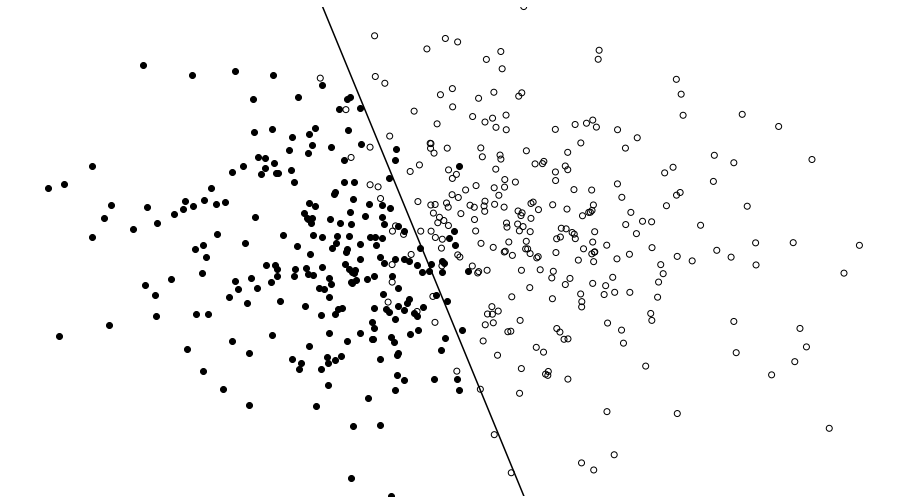

In [19]:
# Plot points
x_plt = np.linspace(x_min[0], x_max[0])
y_plt = -a[0]/a[1] * x_plt - b/a[1]
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', facecolors='none', color='k')
ax.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', color='k')
ax.plot(x_plt, y_plt, color='k')
ax.set_ylim([x_min[1], x_max[1]])
plt.axis('off')
plt.savefig('svm_final.pdf')

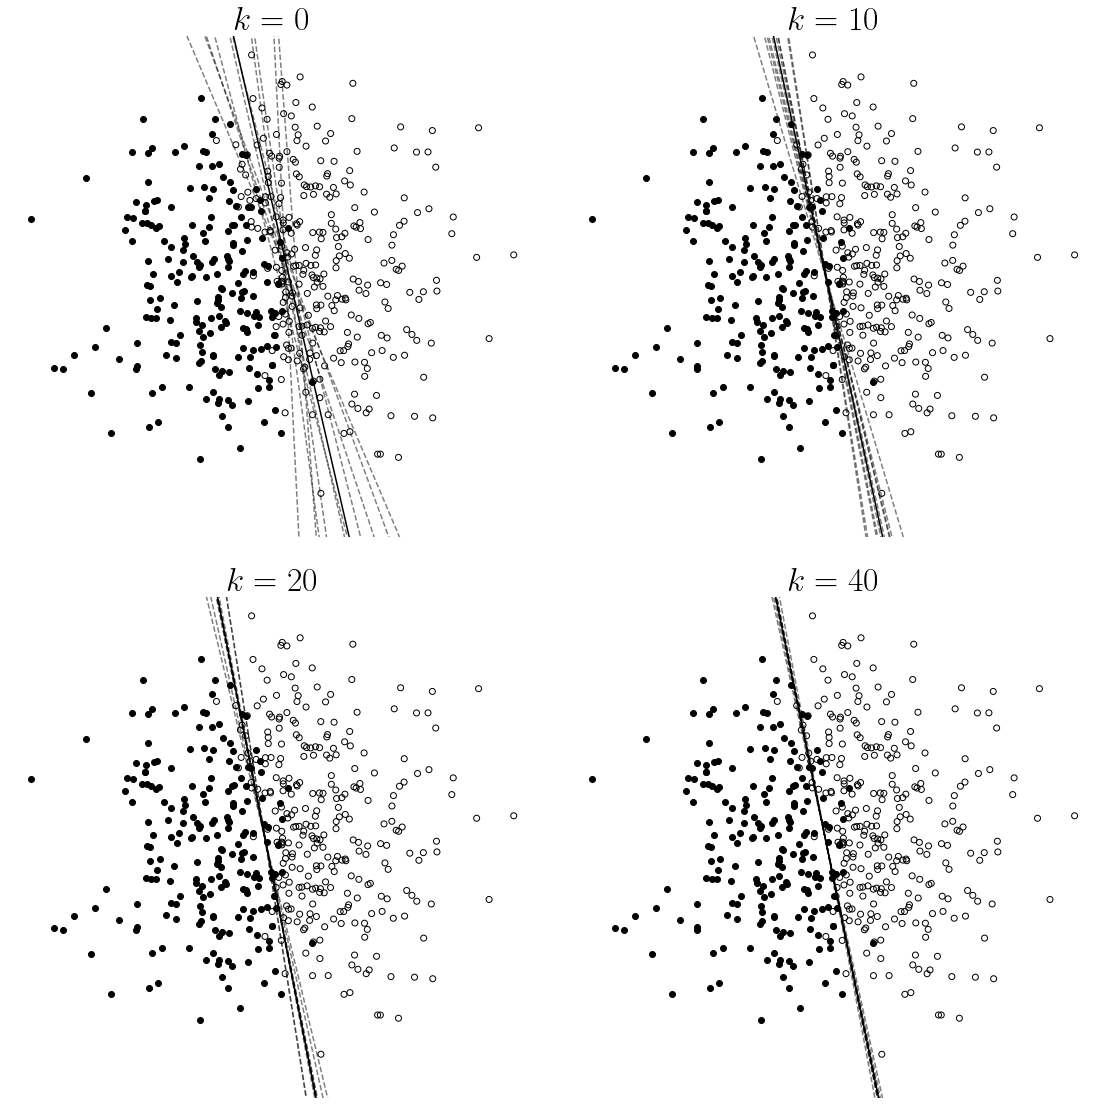

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
axs = ax.ravel()
[axi.set_axis_off() for axi in axs]
k_vec = [0, 10, 20, 40]
x_plt = np.linspace(x_min[0], x_max[0])
for idx in range(len(k_vec)):
    k = k_vec[idx]
    ax = axs[idx]
    ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='o', facecolors='none', color='k')
    ax.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], marker='o', color='k')
    for i in range(n_split):
        x_i = x_val[k][i]
        a_i, b_i = x_i[:-1], x_i[-1]
        y_plt = -a_i[0]/a_i[1] * x_plt - b_i/a_i[1]
        ax.plot(x_plt, y_plt, color='k', linestyle="dashed", alpha=0.5)

    # Plot average
    a, b = z_val[k][:-1], z_val[k][-1]
    y_plt = -a[0]/a[1] * x_plt - b/a[1]
    ax.plot(x_plt, y_plt, color='k')
    ax.set_ylim([x_min[1], x_max[1]])
    ax.set_title(r"$k=%d$" % k)
    #  plt.axis('off')
plt.tight_layout()
plt.savefig('svm_subplots.pdf')